In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cvxpy as cp
import polytope as pc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from cvxpylayers.torch import CvxpyLayer
from tqdm import tqdm
import matplotlib.pyplot as plt

from evanqp import CvxpyProblem, MPCProblem, Polytope, RandomSampler, FFNN, Verifier
from evanqp.layers import BoundArithmetic, BaseLayer, SeqLayer, LinearLayer, ReluLayer, QPLayer
from utils import dlqr

In [3]:
torch.manual_seed(4)
np.random.seed(4)

torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

In [4]:
class DCDCConverter(MPCProblem):
    def __init__(self, N=10):
        self.N = N

        n = 2
        m = 1

        # Linearized dynamics
        self.A = np.array([[0.971356387900839, -0.009766890567613], [1.731870774203751, 0.970462385352837]])
        self.B = np.array([[0.148778899882612], [0.180827260808426]])
        self.C = np.array([[0, 1]])
        
        # Steady state
        ref = 5.0
        ss = np.linalg.solve(np.block([[self.A - np.eye(n), self.B],[self.C, 0]]), np.array([0, 0, ref]))
        self.xs = ss[0:2]
        self.us = ss[2:3]

        # Weights
        self.Q = np.diag([90, 1])
        self.R = np.array([[1]])
        self.K, self.P, _ = dlqr(self.A, self.B, self.Q, self.R)
        
        # Constraints
        self.x_max = np.array([0.2, 7.0])
        self.x_min = np.array([0.0, 0.0])
        self.u_max = np.array([1.0])
        self.u_min = np.array([0.0])
        
        # Terminal Set computation (shifted)
        # state constraints
        Hx = np.vstack((np.eye(n), -np.eye(n)))
        hx = np.concatenate((self.x_max-self.xs, -(self.x_min-self.xs)))
        # input constraints
        Hu = np.vstack((np.eye(m), -np.eye(m)))
        hu = np.concatenate((self.u_max-self.us, -(self.u_min-self.us)))
        # closed loop dynamics
        Ak = self.A - self.B @ self.K
        # state & input constraints
        HH = np.vstack((Hx, -Hu @ self.K))
        hh = np.concatenate((hx, hu))
        # compute maximal invariant set
        O = pc.Polytope(HH, hh)
        while True:
            O_prev = O
            # pre-set
            O = O.intersect(pc.Polytope(O.A @ Ak, O.b))
            if O == O_prev:
                break
        self.F, self.f = O.A, O.b

        self.x0 = cp.Parameter(n, name='x0')
        self.x = cp.Variable((N + 1, n), name='x')
        self.u0 = cp.Variable(m, name='u0')
        self.u = cp.Variable((N, m), name='u')

        objective = cp.quad_form(self.x[N, :] - self.xs, self.P)
        constraints = [self.x0 == self.x[0, :], self.u0 == self.u[0, :]]

        for i in range(N):
            objective += cp.quad_form(self.x[i, :] - self.xs, self.Q) + cp.quad_form(self.u[i, :] - self.us, self.R)
            constraints += [self.x[i + 1, :] == self.A @ self.x[i, :] + self.B @ self.u[i, :]]
            constraints += [self.x_min <= self.x[i, :], self.x[i, :] <= self.x_max]
            constraints += [self.u_min <= self.u[i, :], self.u[i, :] <= self.u_max]
        constraints += [self.F @ (self.x[N, :] - self.xs) <= self.f]

        self.objective = cp.Minimize(objective)
        self.prob = cp.Problem(self.objective, constraints)

    def problem(self):
        return self.prob

    def parameters(self):
        return [self.x0]

    def variables(self):
        return [self.u0]

    def solve(self, x0):
        self.x0.value = x0
        try:
            self.prob.solve(solver=cp.GUROBI)
        except:
            pass

        solution = {self.u0: self.u0.value,
                    self.u: self.u.value,
                    self.x: self.x.value,
                    self.objective: self.objective.value}
        return solution

    def reduced_objective(self):
        objective = cp.quad_form(self.x[self.N, :] - self.xs, self.P)
        for i in range(1, self.N):
            objective += cp.quad_form(self.x[i, :] - self.xs, self.Q) + cp.quad_form(self.u[i, :] - self.us, self.R)
        return cp.Minimize(objective)

In [5]:
mpc_controller = DCDCConverter()

In [7]:
x1 = np.linspace(0, 0.2, 100)
x2 = np.linspace(0, 7, 100)
x, y = np.meshgrid(x1, x2)
z_opt = np.zeros(x.shape)
for i in tqdm(range(x.shape[0])):
    for j in range(x.shape[1]):
        sol = mpc_controller.solve(np.array([x[i, j], y[i, j]]))
        u0 = sol[mpc_controller.variables()[0]]
        z_opt[i, j] = u0 if u0 is not None else None

100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


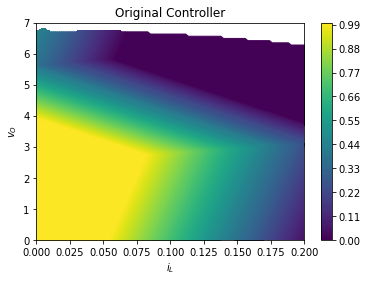

In [8]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, z_opt, levels=100)
for c in cs.collections:
    c.set_edgecolor('face')
fig.colorbar(cs)
ax.set_title('Original Controller')
ax.set_xlabel(r'$i_L$')
ax.set_ylabel(r'$v_O$')
plt.show()

In [9]:
parameter_set = Polytope(np.vstack((np.eye(2), -np.eye(2))), np.concatenate((mpc_controller.x_max, -mpc_controller.x_min)))

In [10]:
sampler = RandomSampler(mpc_controller, parameter_set)
parameter_samples, variable_samples = sampler.sample(5000, seed=0)

100%|██████████| 5000/5000 [00:51<00:00, 97.25it/s] 


In [11]:
parameter_samples = torch.from_numpy(parameter_samples).float()
variable_samples  = torch.from_numpy(variable_samples).float()

torch.save(parameter_samples, 'parameter_samples.pt')
torch.save(variable_samples, 'variable_samples.pt')

In [12]:
parameter_samples = torch.load('parameter_samples.pt')
variable_samples  = torch.load('variable_samples.pt')

In [13]:
class DCDCConverterDataset(Dataset):
    def __init__(self, parameter_samples, variable_samples):
        self.parameter_samples = parameter_samples
        self.variable_samples = variable_samples

    def __len__(self):
        return self.parameter_samples.shape[0]

    def __getitem__(self, idx):
        return self.parameter_samples[idx, :], self.variable_samples[idx, :]

In [14]:
dataset = DCDCConverterDataset(parameter_samples, variable_samples)

seed = 1
train_set_ratio = 0.8

train_set_size = int(len(dataset) * train_set_ratio)
test_set_size = len(dataset) - train_set_size
train_set, test_set = random_split(dataset, [train_set_size, test_set_size], generator=torch.Generator().manual_seed(seed))

In [15]:
class QPLayerProblem(CvxpyProblem):
    def __init__(self, H, nz, eps=1e-4):
        self.z = cp.Variable(nz)
        self.x = cp.Parameter(nz)
        self.prob = cp.Problem(cp.Minimize(cp.sum_squares(H @ self.z + self.x) + eps * cp.sum_squares(self.z)), [self.z >= 0])
        
    def problem(self):
        return self.prob

    def parameters(self):
        return [self.x]

    def variables(self):
        return [self.z]
    
    def solve(self, x):
        self.x.value = x
        self.prob.solve(solver=cp.GUROBI)

        solution = {self.z: self.z.value}
        return solution


class QPModule(nn.Module):
    def __init__(self, nz, eps=1e-4):
        super(QPModule, self).__init__()
        self.H = nn.Parameter(torch.randn(nz, nz))
        self.nz = nz
        self.eps = eps
        H = cp.Parameter((nz, nz))
        prob = QPLayerProblem(H, nz, eps)
        self.layer = CvxpyLayer(prob.problem(), [H] + prob.parameters(), prob.variables())

    def forward(self, x):
        return self.layer(self.H, x, solver_args={'solve_method':'ECOS'})[0]
        
    def milp_layer(self, depth):
        prob = QPLayerProblem(self.H.detach().cpu().numpy(), self.nz, self.eps)
        return QPLayer(prob, depth)

In [16]:
class SatModule(nn.Module):
    def __init__(self, num_features, x_min, x_max):
        super(SatModule, self).__init__()
        self.num_features = num_features
        self.x_min = x_min
        self.x_max = x_max
        
    def forward(self, x):
        return torch.max(torch.min(x, torch.from_numpy(self.x_max).float()), torch.from_numpy(self.x_min).float())
    
    def milp_layer(self, depth):
        return SeqLayer([
            LinearLayer(np.eye(self.num_features), -self.x_min, depth),
            ReluLayer(self.num_features, depth),
            LinearLayer(np.eye(self.num_features), self.x_min, depth),
            LinearLayer(-np.eye(self.num_features), self.x_max, depth),
            ReluLayer(self.num_features, depth),
            LinearLayer(-np.eye(self.num_features), self.x_max, depth)
        ], depth)

In [17]:
nz = 3

net = nn.Sequential(
    nn.Linear(mpc_controller.parameter_size(), nz),
    QPModule(nz),
    nn.Linear(nz, mpc_controller.variable_size()),
    # SatModule(mpc_controller.variable_size(), mpc_controller.u_min, mpc_controller.u_max)
)

In [18]:
def loss_function(model, data, target):
    output = model(data)
    loss = F.mse_loss(output, target)
    loss += 1e2 / len(data) * F.mse_loss(model(torch.from_numpy(mpc_controller.xs).float().to(data.device)), torch.from_numpy(mpc_controller.us).float().to(data.device))
    return loss

In [19]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        loss = loss_function(model, data, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader)

In [20]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            test_loss += loss_function(model, data, target).item()

    test_loss /= len(test_loader)

    print('Test set: Average loss: {:.6f}\n'.format(test_loss))

In [21]:
use_cuda = torch.cuda.is_available()

device = torch.device('cuda' if use_cuda else 'cpu')

train_kwargs = {'batch_size': 50}
test_kwargs = {'batch_size': 1000}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    
train_loader = DataLoader(train_set, **train_kwargs)
test_loader = DataLoader(test_set, **test_kwargs)

In [22]:
optimizer = optim.Adam(net.parameters(), lr=0.01)
for epoch in range(1, 50 + 1):
    train(net, device, train_loader, optimizer, epoch)
    test(net, device, test_loader, epoch)

Train Epoch: 1 [0/4000 (0%)]	Loss: 0.810637
Train Epoch: 1 [1000/4000 (25%)]	Loss: 0.241078
Train Epoch: 1 [2000/4000 (50%)]	Loss: 0.172683
Train Epoch: 1 [3000/4000 (75%)]	Loss: 0.100165
Test set: Average loss: 0.062774

Train Epoch: 2 [0/4000 (0%)]	Loss: 0.070327
Train Epoch: 2 [1000/4000 (25%)]	Loss: 0.043823
Train Epoch: 2 [2000/4000 (50%)]	Loss: 0.041297
Train Epoch: 2 [3000/4000 (75%)]	Loss: 0.040310
Test set: Average loss: 0.024074

Train Epoch: 3 [0/4000 (0%)]	Loss: 0.028665
Train Epoch: 3 [1000/4000 (25%)]	Loss: 0.014248
Train Epoch: 3 [2000/4000 (50%)]	Loss: 0.013463
Train Epoch: 3 [3000/4000 (75%)]	Loss: 0.012999
Test set: Average loss: 0.008199

Train Epoch: 4 [0/4000 (0%)]	Loss: 0.009152
Train Epoch: 4 [1000/4000 (25%)]	Loss: 0.006976
Train Epoch: 4 [2000/4000 (50%)]	Loss: 0.006615
Train Epoch: 4 [3000/4000 (75%)]	Loss: 0.008353
Test set: Average loss: 0.004899

Train Epoch: 5 [0/4000 (0%)]	Loss: 0.004428
Train Epoch: 5 [1000/4000 (25%)]	Loss: 0.005916
Train Epoch: 5 [2000

In [23]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
for epoch in range(1, 10 + 1):
    train(net, device, train_loader, optimizer, epoch)
    test(net, device, test_loader, epoch)

Train Epoch: 1 [0/4000 (0%)]	Loss: 0.004129
Train Epoch: 1 [1000/4000 (25%)]	Loss: 0.005671
Train Epoch: 1 [2000/4000 (50%)]	Loss: 0.005244
Train Epoch: 1 [3000/4000 (75%)]	Loss: 0.005057
Test set: Average loss: 0.004290

Train Epoch: 2 [0/4000 (0%)]	Loss: 0.003724
Train Epoch: 2 [1000/4000 (25%)]	Loss: 0.005875
Train Epoch: 2 [2000/4000 (50%)]	Loss: 0.005224
Train Epoch: 2 [3000/4000 (75%)]	Loss: 0.005047
Test set: Average loss: 0.004285

Train Epoch: 3 [0/4000 (0%)]	Loss: 0.003713
Train Epoch: 3 [1000/4000 (25%)]	Loss: 0.005846
Train Epoch: 3 [2000/4000 (50%)]	Loss: 0.005229
Train Epoch: 3 [3000/4000 (75%)]	Loss: 0.005048
Test set: Average loss: 0.004283

Train Epoch: 4 [0/4000 (0%)]	Loss: 0.003713
Train Epoch: 4 [1000/4000 (25%)]	Loss: 0.005831
Train Epoch: 4 [2000/4000 (50%)]	Loss: 0.005233
Train Epoch: 4 [3000/4000 (75%)]	Loss: 0.005049
Test set: Average loss: 0.004282

Train Epoch: 5 [0/4000 (0%)]	Loss: 0.003712
Train Epoch: 5 [1000/4000 (25%)]	Loss: 0.005823
Train Epoch: 5 [2000

In [24]:
net_sat = nn.Sequential(
    *net,
    SatModule(mpc_controller.variable_size(), mpc_controller.u_min, mpc_controller.u_max)
)

In [25]:
torch.save({'state_dict': net_sat.state_dict()}, 'dc_dc_converter_qp.pt')

In [26]:
saved_model = torch.load('dc_dc_converter_qp.pt')
net_sat.load_state_dict(saved_model['state_dict'])

<All keys matched successfully>

In [27]:
z_net = np.vstack((x.flatten(), y.flatten())).T
z_net = net_sat(torch.from_numpy(z_net).float())
z_net = z_net.detach().cpu().numpy()
z_net = z_net.reshape(x.shape)

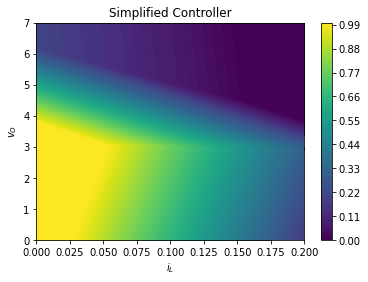

In [28]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, z_net, levels=100)
for c in cs.collections:
    c.set_edgecolor('face')
fig.colorbar(cs)
ax.set_title('Simplified Controller')
ax.set_xlabel(r'$i_L$')
ax.set_ylabel(r'$v_O$')
plt.show()

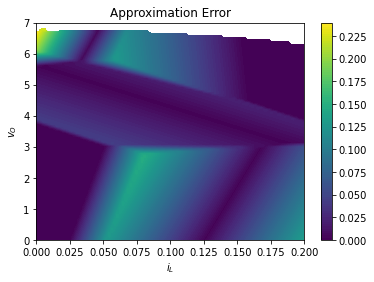

In [29]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, np.abs(z_opt - z_net), levels=100)
for c in cs.collections:
    c.set_edgecolor('face')
fig.colorbar(cs)
ax.set_title('Approximation Error')
ax.set_xlabel(r'$i_L$')
ax.set_ylabel(r'$v_O$')
plt.show()

In [30]:
verifier = Verifier(parameter_set, mpc_controller, net_sat)

In [31]:
mpc_bounds, net_bounds = verifier.compute_bounds(method=BoundArithmetic.ZONO_ARITHMETIC)
print('Neural Network Bounds:')
print(f'lower bound: {net_bounds["lb"]}')
print(f'upper bound: {net_bounds["ub"]}')

Neural Network Bounds:
lower bound: [0.]
upper bound: [1.]


/Users/rschwan/Projects/evanqp/evanqp/layers/qp.py:168: UserWarning: QP Problem is not lower bounded, could lead to increased solve times.
  warnings.warn('QP Problem is not lower bounded, could lead to increased solve times.')
/Users/rschwan/Projects/evanqp/evanqp/layers/qp.py:176: UserWarning: QP Problem is not upper bounded, could lead to increased solve times.
  warnings.warn('QP Problem is not upper bounded, could lead to increased solve times.')


In [32]:
bound, parameters = verifier.find_max_abs_diff()

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Parameter Threads unchanged
   Value: 0  Min: 0  Max: 1024  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 306 rows, 302 columns and 739 nonzeros
Model fingerprint: 0xfbafc9f8
Model has 148 general constraints
Variable types: 229 continuous, 73 integer (73 binary)
Coefficient statistics:
  Matrix range     [2e-04, 2e+100]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e-02, 7e+00]
  RHS range        [7e-18, 5e+97]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

User MIP start did not produce a new incumbent solution
User MIP start violates constraint R303 by 8963389992713925959508598093797274205129920853388244894469630312749878377907738806514367132870901760.000000000

Presolve removed 191 rows and 138 columns
Presolve time: 0.00s
P

In [33]:
print(f'Maximum absolute Error Bound between MPC and NN: {bound} at {parameters}')
u0_mpc = mpc_controller.solve(np.array(parameters))[mpc_controller.u0][0]
u0_net = net_sat(torch.from_numpy(np.array(parameters)).float()).detach().numpy()[0]
print(f'Double Checking by calulcaing error at this position: {u0_mpc - u0_net}')

Maximum absolute Error Bound between MPC and NN: 1.0 at [0.05532338267737391, 0.25777098956245004]
Double Checking by calulcaing error at this position: 0.12987643479082056


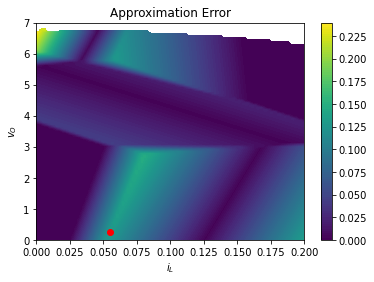

In [34]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, np.abs(z_opt - z_net), levels=100)
for c in cs.collections:
    c.set_edgecolor('face')
ax.plot(parameters[0], parameters[1], 'ro')
fig.colorbar(cs)
ax.set_title('Approximation Error')
ax.set_xlabel(r'$i_L$')
ax.set_ylabel(r'$v_O$')
plt.show()

In [35]:
bound, parameters = verifier.verify_stability(guess=mpc_controller.xs)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Parameter Threads unchanged
   Value: 0  Min: 0  Max: 1024  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 426 rows, 361 columns and 953 nonzeros
Model fingerprint: 0x0a531a3b
Model has 63 quadratic objective terms
Model has 146 general constraints
Variable types: 288 continuous, 73 integer (73 binary)
Coefficient statistics:
  Matrix range     [2e-04, 2e+100]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 3e+02]
  Bounds range     [5e-02, 7e+00]
  RHS range        [7e-18, 5e+97]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

User MIP start did not produce a new incumbent solution
User MIP start violates constraint R423 by 8963389992713925959

In [36]:
print(f'Stability bound: {bound} at {parameters}, should be >=0 for stability')

Stability bound: -0.0002862982695546805 at [0.04951463971002454, 5.011894963748917], should be >=0 for stability
